# Analyze fundamental frequency (FF) of a song syllable

- Take parameters (onset & offset of FF, etc) from ff table
- Read results values from ff_result table
- Some examples of syllables with detected FF
- \# of syllables should be >= 10 to calculate FF

<img src="img/ff_example.png" width=800 height=800 />

## Load data from ff_result table

In [1]:
from analysis.functions import add_pre_normalized_col
from database.load import ProjectLoader
from deafening.plot import plot_across_days_per_note, plot_bar_comparison, plot_paired_data, plot_per_day_block
import pandas as pd
from util import save
import warnings
warnings.filterwarnings('ignore')
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results')  # folder where result figures will be saved

# Load database
df = ProjectLoader().load_db().to_dataframe(f"SELECT * FROM ff_result")
df['block10days'].replace(4, 3, inplace=True)  # include block 4 into block 3
df = add_pre_normalized_col(df, 'ffUndirCV', 'ffUndirCVNorm')  # add a column for normalized ff (normalization by the pre-deafening mean)
df = add_pre_normalized_col(df, 'ffDirCV', 'ffDirCVNorm')  

## Plot CV of FF across days per syllable

- Undir songs only. (Not enough Dir songs)
- Plot the value only if the number of notes >= 10

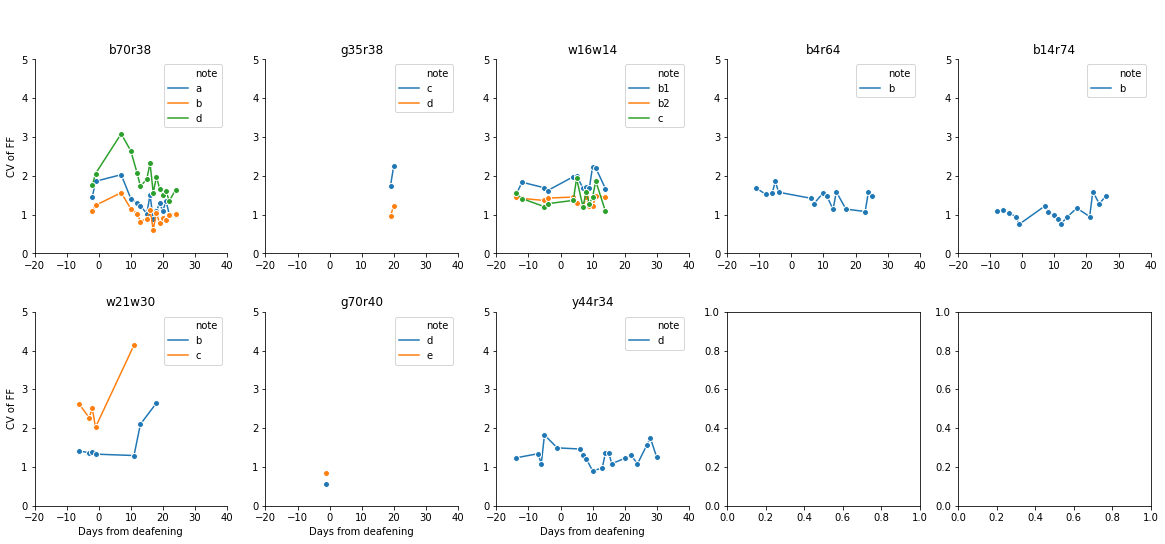

In [2]:
plot_across_days_per_note(df, x='taskSessionDeafening', y='ffUndirCV',
                 x_label='Days from deafening',
                 y_label='CV of FF',
                 title='CV of FF (Undir)', fig_name='FF_across_days',
                 x_lim=[-20, 40], y_lim=[0, 5],
                 save_path=save_path,
                 save_fig=False,
                 )

## Plot normalized CV of FF across days per syllable

- The same data as above (undir songs only).
- Values were normalized by the pre-deafening mean (=1, horizontal dash)

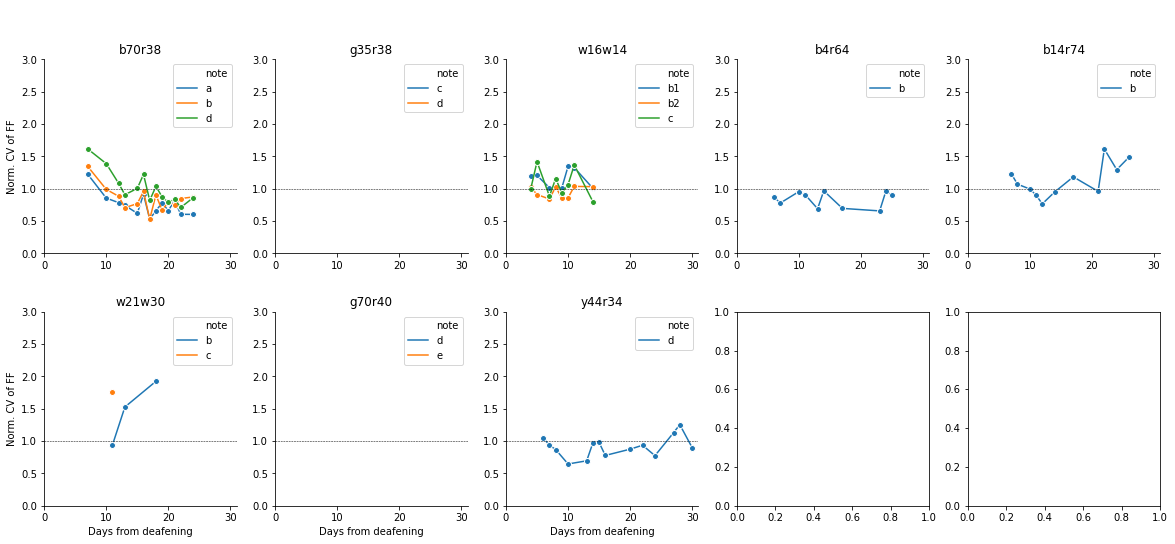

In [3]:
plot_across_days_per_note(df, x='taskSessionDeafening', y='ffUndirCVNorm',
                 x_label='Days from deafening',
                 y_label='Norm. CV of FF',
                 title='CV of FF (Undir)', fig_name='FF_across_days',
                 x_lim=[0, 31],
                 y_lim=[0, 3],
                 hline=1,
                 view_folder=True,
                 save_fig=False,
                 )

## Compare pre-post

taskName     Predeafening  Postdeafening
birdID note                             
b14r74 b          0.98860       1.120636
b4r64  b          1.64080       1.377200
b70r38 a          1.65450       1.249000
       b          1.16300       0.987154
       d          1.90550       1.928769
g35r38 c              NaN       2.005000
       d              NaN       1.101000
g70r40 d          0.56600            NaN
       e          0.84000            NaN
w16w14 b1         1.66025       1.898125
       b2         1.41850       1.346250
       c          1.36325       1.471500
w21w30 b          1.37600       2.014667
       c          2.35300       4.139000
y44r34 d          1.39520       1.275214


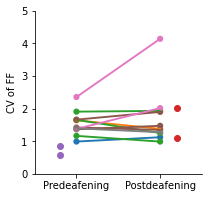

t(24) = -1.054733, p = 0.302 (two-sample t-test)
t(10) = -0.943, p = 0.368 (paired t-test)
Z = -0.487, p = 0.626 (rank-sum test)
Z = 29.0, p = 0.765 (signed-rank test)


In [4]:
df_cv = df.groupby(['birdID', 'note', 'taskName']).mean()['ffUndirCV'].reset_index()
df_cv = pd.pivot_table(data=df_cv,index=['birdID', 'note'], columns=['taskName'])['ffUndirCV']
df_cv = df_cv.reindex(['Predeafening', 'Postdeafening'], axis=1)
print(df_cv)
plot_paired_data(df, x='taskName', y='ffUndirCV',
                 y_label="CV of FF",
                 y_lim=[0, 5],
                 fig_size=(3, 3),
                 fig_name='CV of FF (Undir)',
                 save_fig=False,
                 save_path=save_path,
                 color_by_bird=True,  # color-label birds
                 fig_ext='.png'
                 )

# Run stats
from util.stats import two_sample_ttest, paired_ttest, rank_sum_test, signed_rank_test
df_dropna = df_cv.dropna()  # remove if any of the columns is nan, used for paired comparisons

_, _, msg = two_sample_ttest(df_cv['Predeafening'].values, df_cv['Postdeafening'].values)
print(msg + " (two-sample t-test)")
_, _, msg = paired_ttest(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (paired t-test)")
_, _, msg = rank_sum_test(df_cv['Predeafening'].values, df_cv['Postdeafening'].values)
print(msg + " (rank-sum test)")
_, _, msg = signed_rank_test(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (signed-rank test)")

## Plot across day blocks

In [7]:
save_fig = False
fig_ext = '.png'
df_block = df.groupby(['birdID', 'block10days'])['ffMeanUndir', 'ffUndirCV'].mean().reset_index()  # get the mean entropy & ev per note per block
df_block.dropna(inplace=True)
df_block.head()

,birdID,block10days,ffMeanUndir,ffUndirCV
0,b14r74,0,626.515000,0.988600
1,b14r74,1,629.431667,1.088333
2,b14r74,2,637.326000,0.940250
3,b14r74,3,633.675750,1.325250
4,b4r64,0,699.065200,1.640800


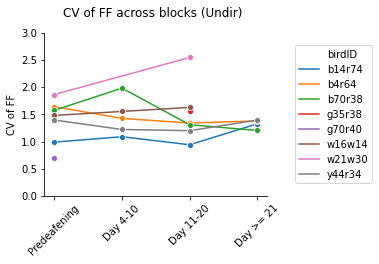

F = 0.211, p = 0.888 (One-way ANOVA)


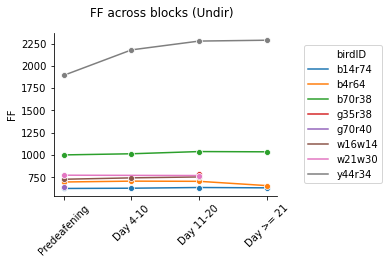

F = 0.155, p = 0.925 (One-way ANOVA)


In [11]:
def plot_across_blocks(df_block, variable, 
                       y_lim=None, fig_size=(4, 3),
                       y_label=None, 
                       fig_name=None, 
                       save_fig=False, save_path=None, 
                       fig_ext='.png'
                       ):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from util.draw import remove_right_top
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.suptitle(fig_name, y=1, fontsize=12)
    sns.lineplot('block10days', variable, hue='birdID', marker='o', data=df_block, ax=ax)
    remove_right_top(ax)
    ax.set_xlabel(''), ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    day_block_label_list = ['Predeafening', 'Day 4-10', 'Day 11-20', 'Day >= 21']
    ax.set_xticklabels(day_block_label_list, rotation=45)
    ax.set_xticklabels(day_block_label_list, rotation=45)
    ax.set_xticks([0, 1, 2, 3])
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    # Run one-way ANOVA
    import scipy.stats as stats
    f_val, p_val = stats.f_oneway(
                                  df_block[variable][df_block['block10days'] == 0],
                                  df_block[variable][df_block['block10days'] == 1],
                                  df_block[variable][df_block['block10days'] == 2],
                                  df_block[variable][df_block['block10days'] == 3],
                                  )

    msg = f"""F ={f_val: 0.3f}, p ={p_val: 0.3f} (One-way ANOVA)"""
    if save_fig:
        save.save_fig(fig, save_path, fig_name, view_folder=view_folder, fig_ext=fig_ext)
    else:
        plt.show()
    print(msg)  

# CV of FF
plot_across_blocks(df_block, variable='ffUndirCV', 
                   fig_name='CV of FF across blocks (Undir)',
                   y_lim=[0, 3], 
                   y_label='CV of FF', 
                   save_fig=save_fig, fig_ext=fig_ext
                   )

# mean FF (mean pitch)
plot_across_blocks(df_block, variable='ffMeanUndir', 
                   fig_name='FF across blocks (Undir)',
                   # y_lim=[0, 3], 
                   y_label='FF', 
                   save_fig=save_fig, fig_ext=fig_ext
                   )



In [9]:
# Create a new column with normalized values
from analysis.functions import add_pre_normalized_col

df_norm = add_pre_normalized_col(df, 'ffMeanUndir', 'ffMeanUndirNorm')
df_norm = add_pre_normalized_col(df_norm, 'ffUndirCV', 'ffUndirCVNorm')